In [1]:
## majority voting for the label
## remove those that don't have majority
## track f1 and accuracy through epochs, save model each epoch, choose the epoch that has max acc 
## Use those params to evaluate on test set. 

import os
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import json
from sklearn.metrics import accuracy_score, classification_report, f1_score

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
def load_data(data_path):
    import json
    with open(data_path, "r") as f:
        data = json.load(f)
    
    #add majority label here and remove those keys that don't have a majority label. 
    non_majority_label_keys = []
    from collections import Counter
    for key, value in data.items():
        labels = [value['annotators'][0]['label'], value['annotators'][1]['label'], value['annotators'][2]['label']]
        counter = Counter(labels)
        most_common_labels = counter.most_common()
        max_count = most_common_labels[0][1]
        
        # Get all labels with the max count (in case of a tie)
        majority_labels = [label for label, count in most_common_labels if count == max_count]
    
        if len(majority_labels) > 1:
            non_majority_label_keys.append(key)
        else:
            value['majority'] = majority_labels[0]
            
    for key in non_majority_label_keys:
        data.pop(key, None)  # Avoids KeyError if key is missing
    
    return data

# Load the HateXplain dataset
def load_hatexplain(data_path, post_id_divisions_path):
    data = load_data(data_path)
    
    train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = [], [], [], [], [], []
    label_map = {"hatespeech": 0, "offensive": 1, "normal": 2}

    post_id_divisions_path = "Data/post_id_divisions.json"
    with open(post_id_divisions_path, "r") as f:
        post_id = json.load(f)
    
    train_data = {k: data[k] for k in post_id["train"] if k in data}
    val_data = {k: data[k] for k in post_id["val"] if k in data}
    test_data = {k: data[k] for k in post_id["test"] if k in data}

    for key, value in train_data.items():
        train_texts.append(" ".join(value["post_tokens"]))
        train_labels.append(label_map[value["majority"]])
        
    for key, value in val_data.items():
        val_texts.append(" ".join(value["post_tokens"]))
        val_labels.append(label_map[value["majority"]])

    for key, value in test_data.items():
        test_texts.append(" ".join(value["post_tokens"]))
        test_labels.append(label_map[value["majority"]])
        
    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels

# Custom PyTorch dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load dataset
data_path = "Data/dataset.json"
post_id_divisions_path = "Data/post_id_divisions.json"

train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = load_hatexplain(data_path, post_id_divisions_path)


/Users/nubster/miniconda3/envs/comp550-final-project/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create PyTorch datasets
train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)
test_dataset = HateSpeechDataset(test_texts, test_labels, tokenizer)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [9]:

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, hidden_dropout_prob=0.1)
model.to(device)

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm

# Training loop with progress bar, accuracy, and F1-score
def train_model(model, train_loader, val_loader, epochs=3, save_dir="saved_models"):
    best_val_acc = 0  # Track highest validation accuracy
    best_model_path = None
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress_bar:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            # Compute training loss and accuracy
            total_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for F1-score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        # Compute metrics
        train_acc = correct / total
        train_f1 = f1_score(all_labels, all_preds, average='macro')

        # Validation evaluation
        val_acc, val_f1 = evaluate(model, val_loader)

        # Save model for this epoch
        model_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), model_path)
        
        # Track the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = model_path  # Save best model path

        print(f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"Best model saved at {best_model_path} with Val Acc: {best_val_acc:.4f}")
    return best_model_path

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:

# Evaluation function with accuracy and F1-score
def evaluate(model, data_loader, final=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            # print(tokenizer.decode(input_ids[0])) to check if it's in order
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    if final:
        print("\nFinal Test Classification Report:\n", classification_report(all_labels, all_preds))

    return accuracy, macro_f1

# Train the model
best_model_path = train_model(model, train_loader, val_loader, epochs=20)


# Evaluate on test set after training
print("\nFinal evaluation on test set:")
model.load_state_dict(torch.load(best_model_path))
test_acc, test_f1 = evaluate(model, test_loader, final=True)
print(f"Test Accuracy: {test_acc:.4f}, Test Macro F1-score: {test_f1:.4f}")


KeyboardInterrupt: 

In [14]:
len(train_labels)

15383

In [6]:
import json
with open("Data/dataset.json", "r") as f:
    data = json.load(f)
    
annotator_ids = []
for post in data.values():
    annotator_ids.extend([annotator["annotator_id"] for annotator in post["annotators"]])

# Convert to Pandas DataFrame and count occurrences
df = pd.DataFrame({"annotator_id": annotator_ids})
annotator_counts = df["annotator_id"].value_counts().reset_index()
annotator_counts.columns = ["annotator_id", "count"]

# Display sorted annotators
print(annotator_counts)

     annotator_id  count
0               4   5730
1               9   2075
2             223   1978
3             203   1918
4             209   1769
..            ...    ...
248           192      3
249           188      3
250           174      3
251           190      2
252           138      1

[253 rows x 2 columns]


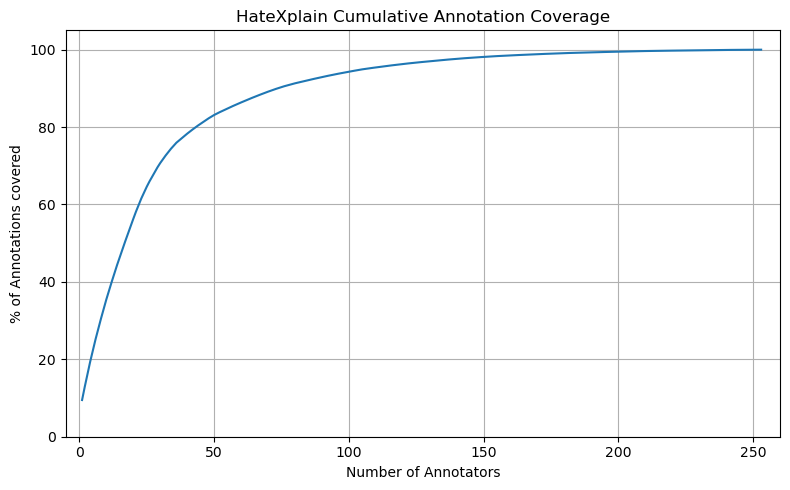

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Your DataFrame already sorted in descending order of annotation count
# df = pd.DataFrame({"annotator_id": [...], "count": [...]})
df = annotator_counts
# Compute total annotations
total = df["count"].sum()
df["cumulative_percentage"] = df["count"].cumsum() / df["count"].sum() * 100

# X-axis: annotator rank
df["annotator_rank"] = range(1, len(df) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df["annotator_rank"], df["cumulative_percentage"])
plt.xlabel("Number of Annotators")
plt.ylabel("% of Annotations covered")
plt.title("HateXplain Cumulative Annotation Coverage")
plt.grid(True)
plt.ylim(0, 105)
plt.xlim(-5, len(df)+7)
plt.tight_layout()
plt.show()

In [18]:
annotator_counts.head(20)

,annotator_id,count
0,4,5730
1,9,2075
2,223,1978
3,203,1918
4,209,1769
5,1,1748
6,6,1614
7,202,1584
8,199,1526
9,211,1494


In [4]:
train_dataset[0]

{'input_ids': tensor([  101,  1057,  2428,  2228,  1045,  2052,  2025,  2031,  2042, 15504,
          2011, 18993,  7560,  2030,  5152,  2067,  1999,  2634,  2030,  7269,
          1998,  1037,  9253,  6394,  2052,  9040,  2033,  2004,  2092,  2074,
          2000,  2156,  2033,  5390,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [6]:
tokenizer.decode(train_dataset[0]["input_ids"])


'[CLS] u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [2]:
import json
post_id_divisions_path = "Data/post_id_divisions.json"
with open(post_id_divisions_path, "r") as f:
    post_id = json.load(f)

In [4]:
len(post_id['test'])

1924

In [5]:
len(post_id['train'])

15383

In [6]:
len(post_id['val'])

1922

In [3]:
len(train_labels)

15383

In [4]:
len(val_labels)

1922

In [5]:
len(test_labels)

1924